In [32]:
!pip install pymoo numpy

Import and Parse Netlist

In [33]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from parse import parse_netlist

with open("flipflop.sp") as f:
    netlist_text = f.read()
V, E = parse_netlist(netlist_text)

pmos_idx = [i for i, t in enumerate(V) if t["type"] == "PMOS"]
nmos_idx = [i for i, t in enumerate(V) if t["type"] == "NMOS"]
NP, NN = len(pmos_idx), len(nmos_idx)
N = max(NP, NN)

print("Vector V:", V)   # [{'id': ..., 'type': ...}, ...]
print("Matrix E:", E)   # [(drain, gate, source), ...]


Vector V: [{'id': 'M1', 'type': 'PMOS'}, {'id': 'M2', 'type': 'NMOS'}, {'id': 'M1', 'type': 'PMOS'}, {'id': 'M2', 'type': 'NMOS'}, {'id': 'Xinv1_M1', 'type': 'PMOS'}, {'id': 'Xinv1_M2', 'type': 'NMOS'}, {'id': 'Xtg1_M1', 'type': 'PMOS'}, {'id': 'Xtg1_M2', 'type': 'NMOS'}, {'id': 'Xinv2_M1', 'type': 'PMOS'}, {'id': 'Xinv2_M2', 'type': 'NMOS'}, {'id': 'Xinv3_M1', 'type': 'PMOS'}, {'id': 'Xinv3_M2', 'type': 'NMOS'}, {'id': 'Xtg2_M1', 'type': 'PMOS'}, {'id': 'Xtg2_M2', 'type': 'NMOS'}, {'id': 'Xtg3_M1', 'type': 'PMOS'}, {'id': 'Xtg3_M2', 'type': 'NMOS'}, {'id': 'Xinv4_M1', 'type': 'PMOS'}, {'id': 'Xinv4_M2', 'type': 'NMOS'}, {'id': 'Xinv5_M1', 'type': 'PMOS'}, {'id': 'Xinv5_M2', 'type': 'NMOS'}, {'id': 'Xinv6_M1', 'type': 'PMOS'}, {'id': 'Xinv6_M2', 'type': 'NMOS'}, {'id': 'Xtg4_M1', 'type': 'PMOS'}, {'id': 'Xtg4_M2', 'type': 'NMOS'}, {'id': 'Xinv_clk_M1', 'type': 'PMOS'}, {'id': 'Xinv_clk_M2', 'type': 'NMOS'}]
Matrix E: [('out', 'in', 'vdd'), ('out', 'in', 'gnd'), ('out', 'in', 'ctrl'), (

Helpers and Problem Define

In [34]:
# -----------------------------
# Helpers
# -----------------------------
def side_nets(drain, source, flip):
    # flip==0: left=drain, right=source; flip==1: left=source, right=drain
    return (drain, source) if flip == 0 else (source, drain)

def make_unique_positions(pos, max_x):
    pos = np.clip(np.round(pos).astype(int), 0, max_x)
    used = set()
    # sweep by current order (stable-ish)
    for i in np.argsort(pos):
        p = pos[i]
        # try right
        while p in used and p < max_x:
            p += 1
        # try left if still used
        if p in used:
            q = pos[i]
            while q in used and q > 0:
                q -= 1
            if q not in used:
                p = q
        # final settle
        if p in used:
            # find any free slot
            for q in range(max_x + 1):
                if q not in used:
                    p = q
                    break
        used.add(p)
        pos[i] = p
    return pos

def derive_groups(xs, flips, idx_map, E):
    """
    Given x-positions and flips for a row, derive contiguous diffusion-sharing groups.
    Returns: group_labels (length = len(xs)), breaks_count
    A break occurs when neighbors are not at consecutive x or their abutting nets don't match.
    """
    m = len(xs)
    order = np.argsort(xs)  # left→right
    labels = np.full(m, -1, dtype=int)
    if m == 0:
        return labels, 0

    current_label = 0
    labels[order[0]] = current_label
    breaks = 0

    for k in range(m - 1):
        i = order[k]
        j = order[k + 1]
        # if not physically adjacent (gap), break regardless
        if xs[j] - xs[i] != 1:
            breaks += 1
            current_label += 1
            labels[j] = current_label
            continue

        # physically adjacent: check net match at the interface
        di, gi, si = E[idx_map[i]]
        dj, gj, sj = E[idx_map[j]]
        iL, iR = side_nets(di, si, flips[i])
        jL, jR = side_nets(dj, sj, flips[j])

        if iR == jL:
            # share diffusion → same group
            labels[j] = current_label
        else:
            # mismatch → diffusion break
            breaks += 1
            current_label += 1
            labels[j] = current_label

    return labels, breaks

# -----------------------------
# Problem
# -----------------------------
class LayoutProblem(Problem):
    """
    Genome layout:
      [0:2*N)          -> placements (row 0 then row 1)
      [2*N:4*N)        -> flips (row 0 then row 1) in {0,1}
    """
    def __init__(self, NP, NN, E):
        self.NP, self.NN, self.E = NP, NN, E
        super().__init__(
            n_var=4 * N,
            n_obj=2,          # [total_breaks, total_span] -> minimize both
            n_constr=0,       # we repair to ensure feasibility
            xl=np.zeros(4 * N, dtype=np.int32),
            xu=np.concatenate([
                np.full(2 * N, N - 1, dtype=np.int32),  # placements
                np.ones(2 * N, dtype=np.int32)          # flips
            ]),
            type_var=np.int32
        )

    def _evaluate(self, X, out, **kwargs):
        F = []

        for x in X:
            x = np.round(x).astype(int)

            # decode
            plc = x[0:2 * N].reshape(2, N)
            flp = x[2 * N:4 * N].reshape(2, N)

            # bounds & uniqueness repair (per row, active count only)
            # PMOS
            plc[0, :self.NP] = make_unique_positions(plc[0, :self.NP], N - 1)
            flp[0, :self.NP] = np.clip(flp[0, :self.NP], 0, 1)

            # NMOS
            plc[1, :self.NN] = make_unique_positions(plc[1, :self.NN], N - 1)
            flp[1, :self.NN] = np.clip(flp[1, :self.NN], 0, 1)

            # derive groups and count breaks (PMOS, NMOS)
            grpP, brkP = derive_groups(plc[0, :self.NP], flp[0, :self.NP], pmos_idx, self.E)
            grpN, brkN = derive_groups(plc[1, :self.NN], flp[1, :self.NN], nmos_idx, self.E)
            total_breaks = brkP + brkN

            # span across both rows (only active sites)
            all_x = np.concatenate([plc[0, :self.NP], plc[1, :self.NN]])
            total_span = int(np.max(all_x) - np.min(all_x)) if len(all_x) > 0 else 0

            F.append([total_breaks, total_span])

        out["F"] = np.array(F, dtype=float)

Run EA and print output

In [35]:
# -----------------------------
# Run EA
# -----------------------------
problem = LayoutProblem(NP, NN, E)

algorithm = NSGA2(
    pop_size=120,
    sampling=IntegerRandomSampling(),
    crossover=SimulatedBinaryCrossover(eta=15, prob=0.9),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    termination=("n_gen", 120),
    seed=42,
    verbose=True
)

# -----------------------------
# Decode & print best solution
# -----------------------------
if res.X is not None:
    sol = np.round(res.X[0]).astype(int)

    plc = sol[0:2 * N].reshape(2, N)
    flp = sol[2 * N:4 * N].reshape(2, N)

    # re-apply repair so prints match what was scored
    plc[0, :NP] = make_unique_positions(plc[0, :NP], N - 1)
    flp[0, :NP] = np.clip(flp[0, :NP], 0, 1)
    plc[1, :NN] = make_unique_positions(plc[1, :NN], N - 1)
    flp[1, :NN] = np.clip(flp[1, :NN], 0, 1)

    # derive groups for reporting
    grpP, brkP = derive_groups(plc[0, :NP], flp[0, :NP], pmos_idx, E)
    grpN, brkN = derive_groups(plc[1, :NN], flp[1, :NN], nmos_idx, E)

    # pack groups into 2xN for print
    grp = -np.ones((2, N), dtype=int)
    grp[0, :NP] = grpP
    grp[1, :NN] = grpN

    print("\nPlacement:\n", plc[:, :N])
    print("\nFlip Bits:\n", flp[:, :N])
    print("\nDerived Groups (contiguous & net-consistent):\n", grp[:, :N])
    print("\nBreaks: PMOS =", brkP, ", NMOS =", brkN, ", Total =", brkP + brkN)
else:
    print("\nNo valid solution found — try larger pop_size/n_gen.")


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      120 |      1 |             - |             -
     2 |      240 |      1 |  0.000000E+00 |             f
     3 |      360 |      2 |  0.000000E+00 |             f
     4 |      480 |      6 |  0.000000E+00 |             f
     5 |      600 |      6 |  0.000000E+00 |             f
     6 |      720 |      1 |  1.0000000000 |         ideal
     7 |      840 |      2 |  0.000000E+00 |             f
     8 |      960 |      2 |  0.000000E+00 |             f
     9 |     1080 |      3 |  0.000000E+00 |             f
    10 |     1200 |      5 |  0.000000E+00 |             f
    11 |     1320 |      9 |  0.000000E+00 |             f
    12 |     1440 |     14 |  0.000000E+00 |             f
    13 |     1560 |     18 |  0.000000E+00 |             f
    14 |     1680 |      3 |  1.0000000000 |         ideal
    15 |     1800 |      1 |  1.0000000000 |         ideal
    16 |     1920 |      3 |  0.000000E+00 |            

Parser & X-sorted check

In [36]:
import numpy as np
from parse import parse_netlist

# 1) Get V,E from parser
with open("flipflop.sp") as f:
    V_text = f.read()
V, E = parse_netlist(V_text)

pmos_idx = [i for i,t in enumerate(V) if t["type"].upper()=="PMOS"]
nmos_idx = [i for i,t in enumerate(V) if t["type"].upper()=="NMOS"]

# 2) placement/flip
plcP = plc[0, :N].tolist()
plcN = plc[1, :N].tolist()
flpP = flp[0, :N].tolist()
flpN = flp[1, :N].tolist()

def side_nets(d, s, flip):  # left,right
    return (d, s) if flip==0 else (s, d)

def validate_row(xs, fs, idx_map, row_name):
    xs = np.asarray(xs, int)
    fs = np.asarray(fs, int)
    assert len(xs)==len(idx_map)==len(fs), f"{row_name}: length mismatch with parsed devices"

    # Check unique positions
    unique_ok = (len(set(xs))==len(xs))

    # Sort by x and scan to derive groups + count breaks
    order = np.argsort(xs)
    labels = np.full(len(xs), -1, int)
    breaks = 0
    cur_lab = 0
    labels[order[0]] = cur_lab

    for a,b in zip(order, order[1:]):
        # need physical adjacency to even try sharing
        if xs[b]-xs[a] != 1:
            breaks += 1
            cur_lab += 1
            labels[b] = cur_lab
            continue
        # check net match at interface (after flips)
        d1,g1,s1 = E[idx_map[a]]
        d2,g2,s2 = E[idx_map[b]]
        _, r1 = side_nets(d1, s1, fs[a])
        l2, _ = side_nets(d2, s2, fs[b])
        if r1 == l2:
            labels[b] = cur_lab          # share -> same strip
        else:
            breaks += 1
            cur_lab += 1
            labels[b] = cur_lab

    print(f"\n[{row_name}]")
    print("  unique positions:", unique_ok)
    print("  x-sorted:", xs[order].tolist())
    print("  group labels (x-order):", [labels[i] for i in order])
    print("  breaks:", breaks)
    return breaks

print("Parsed counts -> PMOS:", len(pmos_idx), " NMOS:", len(nmos_idx))
bp = validate_row(plcP, flpP, pmos_idx, "PMOS")
bn = validate_row(plcN, flpN, nmos_idx, "NMOS")
print("\nTOTAL breaks =", bp+bn)


Parsed counts -> PMOS: 13  NMOS: 13

[PMOS]
  unique positions: True
  x-sorted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  group labels (x-order): [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(3), np.int64(4), np.int64(4), np.int64(5), np.int64(5)]
  breaks: 5

[NMOS]
  unique positions: True
  x-sorted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  group labels (x-order): [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(6), np.int64(6), np.int64(7)]
  breaks: 7

TOTAL breaks = 12


Stick Diagram

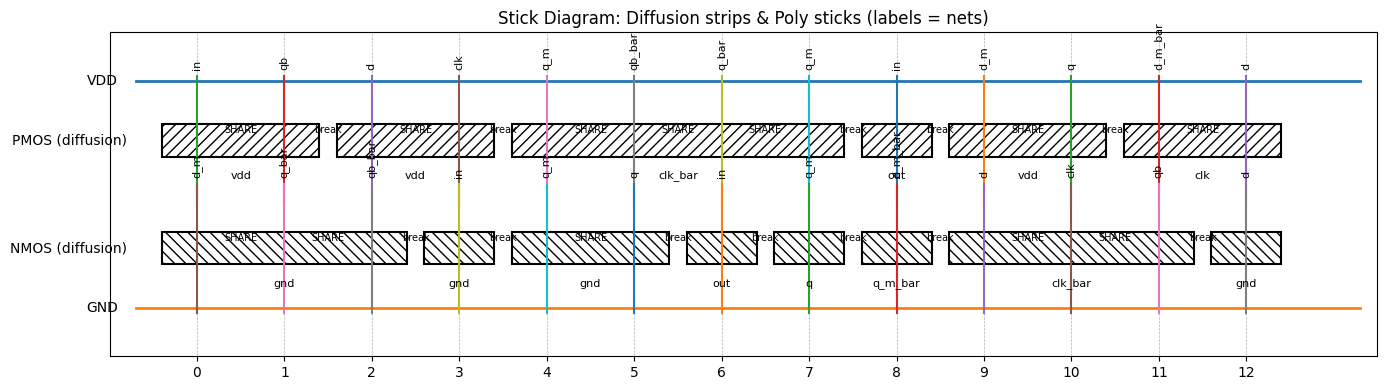

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def side_nets(d, s, flip):
    # flip==0: left=drain,right=source; flip==1: left=source,right=drain
    return (d, s) if flip == 0 else (s, d)

def derive_strips(xs, fs, E, idx_map):
    """
    From placement xs and flips fs, derive diffusion strips as contiguous, net-consistent runs.
    Returns (strips, order). Each strip: {"x0","x1","net","members"} where members are indices into xs.
    """
    xs = np.asarray(xs, int)
    fs = np.asarray(fs, int)
    order = np.argsort(xs)
    strips = []
    if len(order) == 0:
        return strips, order

    # Start first strip
    cur = [order[0]]
    d0, g0, s0 = E[idx_map[order[0]]]
    cur_left_net = side_nets(d0, s0, fs[order[0]])[0]
    shared_net = None  # internal shared net once established

    for a, b in zip(order, order[1:]):
        xa, xb = xs[a], xs[b]
        if xb - xa != 1:
            # Not physically adjacent -> close current strip
            strips.append({
                "x0": xs[cur[0]],
                "x1": xs[cur[-1]],
                "net": shared_net if shared_net is not None else cur_left_net,
                "members": cur[:]
            })
            # Start new strip at b
            cur = [b]
            dB, gB, sB = E[idx_map[b]]
            cur_left_net = side_nets(dB, sB, fs[b])[0]
            shared_net = None
            continue

        d1, g1, s1 = E[idx_map[a]]
        d2, g2, s2 = E[idx_map[b]]
        _, r1 = side_nets(d1, s1, fs[a])   # right net of left device
        l2, _ = side_nets(d2, s2, fs[b])   # left net of right device

        if r1 == l2:
            cur.append(b)
            if shared_net is None:
                shared_net = r1
        else:
            strips.append({
                "x0": xs[cur[0]],
                "x1": xs[cur[-1]],
                "net": shared_net if shared_net is not None else cur_left_net,
                "members": cur[:]
            })
            cur = [b]
            dB, gB, sB = E[idx_map[b]]
            cur_left_net = side_nets(dB, sB, fs[b])[0]
            shared_net = None

    # Close last
    strips.append({
        "x0": xs[cur[0]],
        "x1": xs[cur[-1]],
        "net": shared_net if shared_net is not None else cur_left_net,
        "members": cur[:]
    })
    return strips, order

def draw_row(ax, y, xs, fs, E, idx_map, title, hatch):
    strips, order = derive_strips(xs, fs, E, idx_map)

    # Diffusion strips (hatched rectangles)
    for st in strips:
        x0, x1 = int(st["x0"]), int(st["x1"])
        w = (x1 - x0) + 0.8
        rect = Rectangle((x0 - 0.4, y - 0.15), w, 0.3, fill=False, hatch=hatch, linewidth=1.5)
        ax.add_patch(rect)
        ax.text((x0 + x1)/2, y - 0.28, st["net"], ha='center', va='top', fontsize=8)

    # Poly sticks per transistor with gate labels
    xs = np.asarray(xs, int)
    fs = np.asarray(fs, int)
    for i in order:
        x = int(xs[i])
        d, g, s = E[idx_map[i]]
        ax.plot([x, x], [y - 0.6, y + 0.6], linewidth=1.5)   # poly
        ax.text(x, y + 0.65, g, ha='center', va='bottom', fontsize=8, rotation=90)

    # Interface tags: SHARE / break / gap
    seq = list(order)
    for a, b in zip(seq, seq[1:]):
        xa, xb = int(xs[a]), int(xs[b])
        if xb - xa == 1:
            d1, g1, s1 = E[idx_map[a]]
            d2, g2, s2 = E[idx_map[b]]
            _, r1 = side_nets(d1, s1, fs[a])
            l2, _  = side_nets(d2, s2, fs[b])
            tag = "SHARE" if r1 == l2 else "break"
        else:
            tag = "gap"
        ax.text((xa + xb)/2, y + 0.05, tag, ha='center', va='bottom', fontsize=7)

    # Row label
    ax.text(-0.8, y, title, ha='right', va='center', fontsize=10)

def plot_stick_diagram(V, E, plc, flp, save_path=None, draw_rails=True):
    """
    V: [{'id':..., 'type': 'PMOS'|'NMOS'}, ...]
    E: [(drain, gate, source), ...] aligned with V by index
    plc: shape (2, N) -> x positions for PMOS (row 0) and NMOS (row 1)
    flp: shape (2, N) -> flip bits for PMOS (row 0) and NMOS (row 1)
    """
    # Make sure arrays
    plc = np.asarray(plc, int)
    flp = np.asarray(flp, int)

    pmos_idx = [i for i,t in enumerate(V) if t["type"].upper()=="PMOS"]
    nmos_idx = [i for i,t in enumerate(V) if t["type"].upper()=="NMOS"]

    fig, ax = plt.subplots(figsize=(14, 4))

    # Optional: top/bottom rails
    if draw_rails:
        xmax = int(max(plc[0].max(), plc[1].max()))
        # VDD rail above PMOS
        ax.plot([-0.7, xmax + 1.3], [1.55, 1.55], linewidth=2.0)
        ax.text(-0.9, 1.55, "VDD", ha='right', va='center', fontsize=10)
        # GND rail below NMOS
        ax.plot([-0.7, xmax + 1.3], [-0.55, -0.55], linewidth=2.0)
        ax.text(-0.9, -0.55, "GND", ha='right', va='center', fontsize=10)

    # Rows
    draw_row(ax, y=1.0, xs=plc[0], fs=flp[0], E=E, idx_map=pmos_idx, title="PMOS (diffusion)", hatch="///")
    draw_row(ax, y=0.0, xs=plc[1], fs=flp[1], E=E, idx_map=nmos_idx, title="NMOS (diffusion)", hatch="\\\\\\")

    # Axes cosmetics
    xmax = int(max(plc[0].max(), plc[1].max()))
    ax.set_xlim(-1, xmax + 1.5)
    ax.set_ylim(-1.0, 2.0)
    ax.set_xticks(range(0, xmax + 1))
    ax.set_yticks([])
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
    ax.set_title("Stick Diagram: Diffusion strips & Poly sticks (labels = nets)")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180)
    plt.show()

#plot_stick_diagram(V, E, plc, flp, save_path=None)
plot_stick_diagram(V, E, plc, flp, save_path="stick_diagram.png")
